In [9]:
using Revise
using CMF
import PyPlot; plt = PyPlot
using WAV
using DSP
using JLD

### Load data

In [33]:
path = "/home/anthony/Downloads/Rachmaninoff.wav"
signal, fs = WAV.wavread(path);

# Downsample to 8 Khz
fs_new = 8e3
p = Int(round(fs / fs_new))
signal = signal[1:p:end];

# Create spectrogram
spect = spectrogram(signal, 512, 384; window=DSP.hanning)
t = time(spect)
f = freq(spect)
data = log10.(spect.power .+ 1)
data = data .+ abs(minimum(data))
;

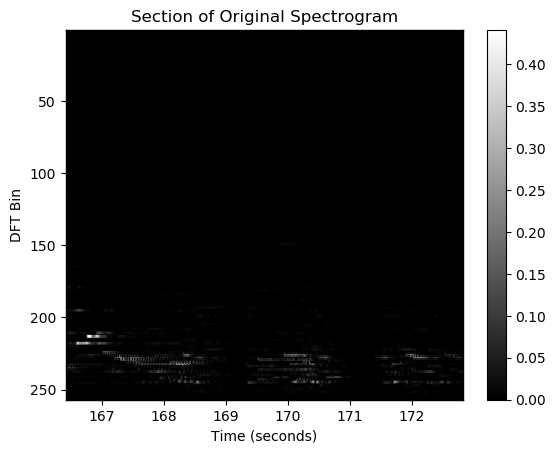

(257, 336946)


In [39]:
# Show section of spectrogram
start_idx = 10_400
end_idx = 10_800

# Plot spectogram and label X axis with seconds
fig, ax = plt.subplots()
ax.grid(false)
CMF.format_imshow_axis(ax; remove_ticks=false)
plt.imshow(data[:,start_idx:end_idx], aspect="auto", origin="lower",
                extent=[t[start_idx]/fs_new, t[end_idx]/fs_new, size(data,1), 1], 
                cmap="gray")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("DFT Bin")
plt.title("Section of Original Spectrogram")
plt.colorbar()

println(size(data))

### Fit Model

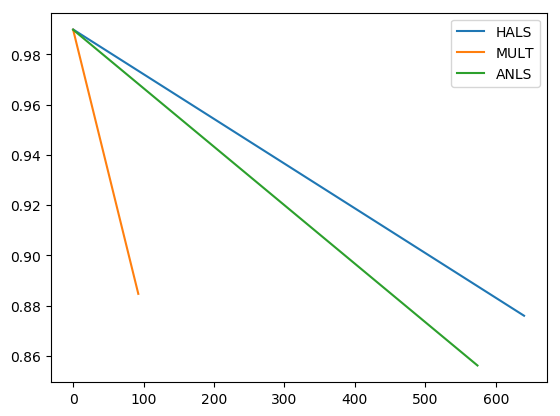

PyObject <matplotlib.legend.Legend object at 0x7f702d5683c8>

In [40]:
runtime = 5  #60 * 60
alg_results = Dict()

plt.figure()
for (alg, label) in [
    [:hals, "HALS"],
    [:mult, "MULT"],
    [:anls, "ANLS"],

]
    results = CMF.fit_cnmf(
        data; L=12, K=20,
        alg=alg, max_itr=Inf, max_time=runtime,
        check_convergence=false
    )

    plt.plot(results.time_hist, results.loss_hist, label=label)
    alg_results[label] = results
end

plt.legend()

In [41]:
JLD.save("concerto.jld", alg_results)

### Plot results

In [43]:
results = JLD.load("concerto.jld");

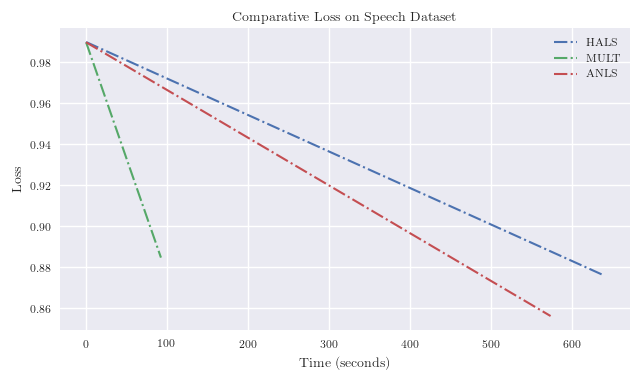

In [47]:
include("./plot_settings.jl")

algs = ["HALS", "MULT", "ANLS"]
fig, ax = plt.subplots(figsize=set_size(doc_textwidth; aspect=0.6))


for alg in algs
        r = results[alg]
        ax.plot(
            r.time_hist, r.loss_hist,
            label=alg,
        )
end
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Comparative Loss on Speech Dataset")


plt.tight_layout()
plt.savefig("./concerto.pdf", format="pdf")